# Calculation the price of cars for the service "Not damaged, not painted"

The "Not Damaged, Not Painted" service for selling used cars with mileage is developing an application to attract new customers. In it, you can quickly find out the market value of your car. You have historical data: technical characteristics, equipment and prices of cars. You need to build a model to determine the cost.

The customer's priorities are:

- quality of prediction;
- speed of prediction;
- training time.


<a id='To-contents'></a>
**Project Contents** \
[Data Preparation](#Data_Preparation)\
[Correlation Analysis](#Correlation_Analysis)\
[Model Training](#Model_Training)\
[Overall Conclusion](#Conclusion)\


In [1]:
%%capture
!pip install phik
!pip install scipy=1.13.1
!pip install numpy=1.26.4
!pip install catboost
!pip install lightgbm
!pip install category_encoders
!pip install --upgrade scikit-learn seaborn

In [2]:
import numpy as np
print(np.__version__)

import phik
print(phik.__version__)

import scipy
print(scipy.__version__)

import sklearn
print(sklearn.__version__)

1.26.4
0.12.4
1.14.1
1.5.2


In [3]:
# import libaries before starting the project
import pandas as pd
import numpy as np
import random
import re
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st
from IPython.display import display, Markdown

# loading pipeline
from sklearn.pipeline import Pipeline

# loading classes for data preparation
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from category_encoders import BinaryEncoder


# loading class for working with gaps
from sklearn.impute import SimpleImputer

# import GridSearchCV
from sklearn.model_selection import GridSearchCV

# loading models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cb

# load metrics function
from sklearn.metrics import mean_squared_error

# tests for checking correlations
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

import warnings
warnings.filterwarnings('ignore',category=UserWarning)

In [ ]:
# bring out the block with settings and functions

# set the standard for dataframe
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.mode.chained_assignment = None # switch off warning after calling columns

try:
    pd.set_option('future.no_silent_downcasting', True)
except:
    pass

# display info about the dataframe
def get_info(dataset):
    display(dataset.info(), dataset.head(5), dataset.tail(5))

# display hist and boxplot
def hist_box(data,column,hue=None):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
    
    if hue == None:
        
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     legend='auto', ax=ax)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     hue=hue, 
                     multiple='stack',
                     legend='auto', ax=ax)
        

    ax = axes[1]
    sns.boxplot(x=data[column], color=random_color, ax=ax)
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show();


# function for grouping by mileage
def group(km):
    if km <= 135000:
        return ((km - 1) // 15000 + 1) * 15000
    else:
        return 150000

# function for calculating absolute values for indicating on a pie chart
def absolute_value(val,df):
    a = round(val/100.*df.sum())
    return a

# function for plotting pie chart
def pieplot(data,column):
    data_grouped = data.groupby(column)[column].count()
    data.groupby(column)[column].count().plot(kind='pie', 
             title ='Признак {}\n'.format(column),
             radius=1.3,
             ylabel='',
             autopct=lambda x: f'{x:.1f}%',
             pctdistance=0.6 );

<a id='Data_Preparation'></a>
## Data Preparation and Analysis
[To content](#To-contents)

In [5]:
# import data
try:
    autos = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_11_Autosales/autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')
    

In [6]:
# look at the data
get_info(autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [7]:
# convert column names to lower case
autos.columns = [i.lower() for i in autos.columns]

# convert all text values to lower case
autos = autos.apply(lambda col: col.apply(lambda x: x.lower() if isinstance(x, str) else x))

autos.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [8]:
# convert dates to datetime
columns_date = ['datecrawled','datecreated','lastseen']

for column in columns_date:
    autos[column]= pd.to_datetime(autos[column], format='%Y-%m-%d %H:%M:%S')

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  repaired           283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

In [9]:
# check unique values in text columns
columns_str = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand','repaired']

for column in columns_str:
    display(autos[column].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

array([nan, 'yes', 'no'], dtype=object)

In [10]:
# displaying the number of missing values in text data
display(autos[columns_str].isna().sum())

# replace missing values with 'other' as this category is already present in most of the features
for column in columns_str:
    autos[column]=autos[column].fillna('other')

# and check once again
autos.info();

vehicletype    37490
gearbox        19833
model          19705
fueltype       32895
brand              0
repaired       71154
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        354369 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            354369 non-null  object        
 5   power              354369 non-null  int64         
 6   model              354369 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           354369 non-null  object        
 10  brand              354369 non-null  object        
 11  repaired           354369 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

In [11]:
# replace typos and implicit duplicates in text columns
autos['model'] = autos['model'].replace('rangerover', 'range_rover')
autos['fueltype'] = autos['fueltype'].replace({'gasoline': 'petrol', 'lpg': 'cng'})

In [12]:
# in column with the number of photos, it seems that there are only zeros - let's check
print('The number of records with missing photos: ', autos[autos['numberofpictures'] == 0]['numberofpictures'].count())

The number of records with missing photos:  354369


In [13]:
# remove inconsistent data: records with registration year after data crawling date
autos = autos[(autos['registrationyear'])<(autos['datecrawled'].dt.year)]

In [14]:
# column with pictures is not informative, also columns with time data on the date of uploading the application and the last activity of the user
# these technical parameters do not affect the price, unlike the date of uploading the application, since the price in time for the same car can change

display(autos.head(3))
autos = autos.drop(columns=['datecrawled', 'numberofpictures', 'lastseen'])
autos.head(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016-03-14,0,90480,2016-04-05 12:47:46


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,postalcode
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other,2016-03-24,70435
1,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24,66954
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other,2016-03-14,90480


In [15]:
# check for duplicates
print('Quantity of duplicates: ',autos.duplicated().sum())

#remove duplicates
autos = autos.drop_duplicates()

Quantity of duplicates:  9860


,price,power,kilometer
count,320380.000,320380.000,320380.000
mean,4519.511,111.740,127939.197
std,4558.165,184.029,37955.658
min,0.000,0.000,5000.000
25%,1100.000,70.000,125000.000
50%,2800.000,105.000,150000.000
75%,6500.000,143.000,150000.000
max,20000.000,20000.000,150000.000


Distribution of quantitative variables in the autos dataset: 



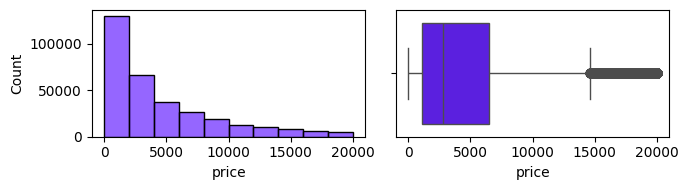

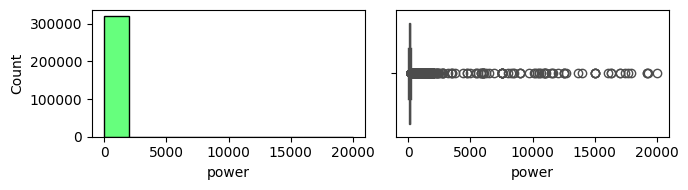

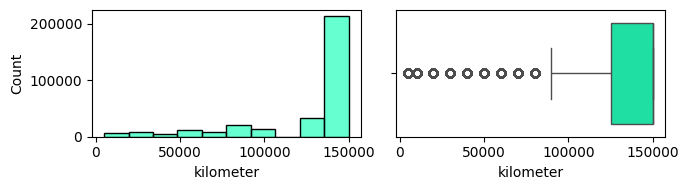

In [16]:
# build histogram and boxplot for quantitative variables

columns_num = ['price', 'power', 'kilometer']

display(autos[columns_num].describe())

print(f'Distribution of quantitative variables in the autos dataset: \n')    
for index, column in enumerate(columns_num):
    hist_box(autos,column);

In the Power column visible abnormal values in 0-10 horsepower and more than 500 and even 1000 horsepower, which is extremely unlikely for mass production vehicles, let's count their number.

In [17]:
print('Number of vehicles with abnormal engine power values: ', autos[(autos['power'] < 15) | (autos['power'] > 500)]['power'].count())

Number of vehicles with abnormal engine power values:  33777


There are enough such records, ignoring anomalous values is not correct - it will affect the quality of model training, deleting 10% of records is also unacceptable, therefore we will replace power values less than 15 horsepower or greater than 500 in the 'power' column with median values corresponding to model and year of registration of other vehicles in the dataset.

In [ ]:
# fix the condition for filtering out incorrect rows
condition = ((autos['power'] < 15) | (autos['power'] > 500))

# take only valid rows for calculation of the median
valid_autos = autos[~condition]

# calculate the median values for each group (model and registration year) without considering invalid rows
medians = valid_autos.groupby(['model', 'registrationyear'])['power'].median()
medians = medians.astype(int)
medians_dict = medians.to_dict()

# replace the anomalous values with the median values
autos.loc[condition, 'power'] = autos.loc[condition].apply(
    lambda row: medians_dict.get((row['model'], row['registrationyear']), row['power']), axis=1)


Количество автомодилей с аномальными значениями мощности двигателя:  353


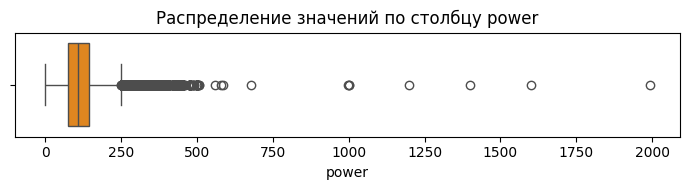

In [ ]:
print('Number of vehicles with anomalous engine power values: ', autos[(autos['power'] < 15) | (autos['power'] > 500)]['power'].count())

palette = sns.color_palette('hsv', n_colors=10)
random_color = random.choice(palette)
plt.figure(figsize=(7, 2))
sns.boxplot(x=autos['power'], color=random_color)
plt.ylabel('')
plt.title('Distribution of values in the `power` column')
plt.tight_layout()
plt.show()

After the previous operation, we have a small pool of records with incorrect data for which no group (and therefore median value) was found by year of registration and model.
We will perform an analogous operation on these records, but calculate the median only by model, which is less accurate but more relevant to 0 or 5,000 horsepower.

In [ ]:
# calculation of median values for each group (model) without taking into account incorrect lines
medians = valid_autos.groupby('model')['power'].median()
medians = medians.astype(int)
medians_dict = medians.to_dict()

autos.loc[condition, 'power'] = autos.loc[condition].apply(
    lambda row: medians_dict.get((row['model']), row['power']), axis=1)

In [21]:
autos[(autos['power'] < 15) | (autos['power'] > 500)]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,postalcode
234296,3800,wagon,1978,manual,0,serie_1,30000,0,petrol,land_rover,other,2016-03-30,49824
280216,0,other,1970,other,0,serie_1,100000,0,petrol,land_rover,other,2016-04-02,88634


There are only two models left for which there is no other option; we will fill them in manually with median values grouped by brand and year.

In [22]:
autos.loc[280216,'power'] = autos[(autos['brand'] == 'land_rover')&(autos['registrationyear'] == 1970)&(autos['power'] != 0)]['power'].median()
autos.loc[234296,'power'] = autos[(autos['brand'] == 'land_rover')&(autos['registrationyear'] == 1978)&(autos['power'] != 0)]['power'].median()

There are anomalies observed in prices with minimum prices for vehicles at the level of 0-100; let's count them.

Количество автомодилей с аномальными значениями цен:  11462


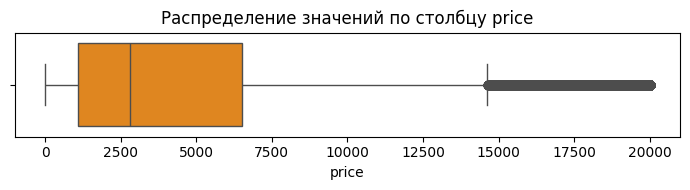

In [ ]:
print('Number of vehicles with anomalous price values: ', autos[(autos['price'] < 100)]['price'].count())

palette = sns.color_palette('hsv', n_colors=10)
random_color = random.choice(palette)
plt.figure(figsize=(7, 2))
sns.boxplot(x=autos['price'], color=random_color)
plt.ylabel('')
plt.title('Distribution of values in the `price` column')
plt.tight_layout()
plt.show()

We will replace anomalously low prices with medians calculated by similar categories of vehicles, adding categories by mileage for accuracy as mileage is an important factor in assessing value and accounting for these groups in calculating the median price.

In [24]:
autos['kilometer_group'] = autos['kilometer'].apply(group)

In [ ]:
# fix the condition for filtering out invalid rows
condition = (autos['price'] < 100) 

# take only valid rows for computing medians
valid_autos = autos[~condition]

# calculate medians for each group (model, registration year, mileage) without invalid rows
medians = valid_autos.groupby(['model', 'registrationyear','kilometer_group'])['price'].median()
medians = medians.astype(int)
medians_dict = medians.to_dict()

# replace outliers with medians
autos.loc[condition, 'price'] = autos.loc[condition].apply(
    lambda row: medians_dict.get((row['model'], row['registrationyear'],row['kilometer_group']), row['price']), axis=1)

In [26]:
autos[(autos['price'] < 100)]['price'].count()

420

In [ ]:
# for autos that we don't have groups for, we'll calculate median values for groups by model and registration year
medians = valid_autos.groupby(['model', 'registrationyear'])['price'].median()
medians = medians.astype(int)
medians_dict = medians.to_dict()

# replace outliers with median values
autos.loc[condition, 'price'] = autos.loc[condition].apply(
    lambda row: medians_dict.get((row['model'], row['registrationyear']), row['price']), axis=1)

In [28]:
autos[(autos['price'] < 100)]['price'].count()

117

In [ ]:
# for autos that have no such groups, we will calculate the median values simply by model
medians = valid_autos.groupby(['model'])['price'].median()
medians = medians.astype(int)
medians_dict = medians.to_dict()

# replace outliers with median values
autos.loc[condition, 'price'] = autos.loc[condition].apply(
    lambda row: medians_dict.get((row['model']), row['price']), axis=1)

In [30]:
autos[(autos['price'] < 100)]['price'].count()

0

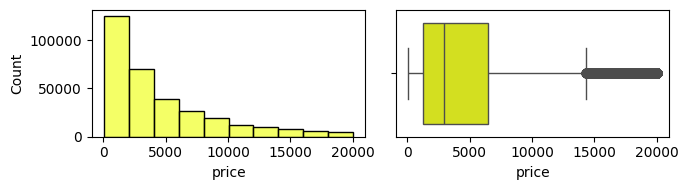

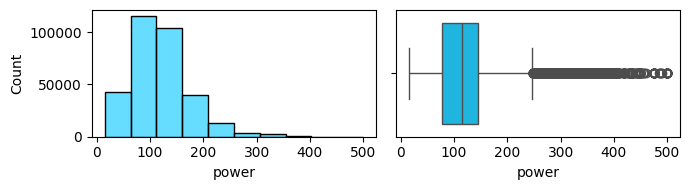

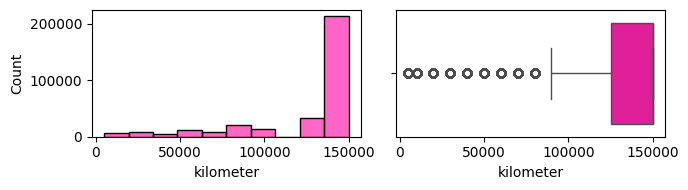

In [ ]:
# look at the data with changes
for index, column in enumerate(columns_num):
    hist_box(autos,column);

We will examine the categorical features: vehicletype, gearbox, fueltype, repaired by building pie charts for these four variables.
For the remaining features: registrationyear, model, brand, datecreated, postalcode, kilometer_group - with too many values for a pie chart, we will consider them using bar plots and histograms.

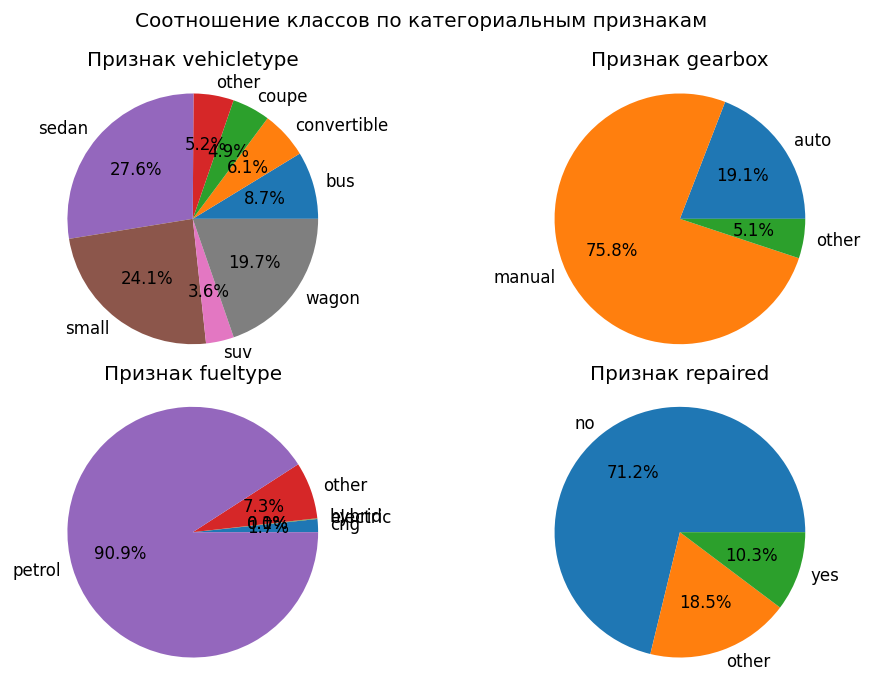

In [ ]:
# plot graphs of type pie for categorical data from the first part of the item above
columns_cat_1 = ['vehicletype', 'gearbox','fueltype','repaired']

plt.figure(figsize=[10, 6], dpi=120)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.suptitle('Distribution of classes by categorical features', y=1)

for i,column in enumerate(columns_cat_1):
    
    plt.subplot(2,2,i+1)
    pieplot(autos,column);

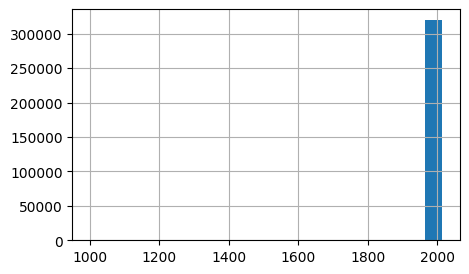

In [ ]:
# build histogram of car release years

plt.figure(figsize=[5, 3])
autos['registrationyear'].hist(bins=20);

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])


Количество записей с некорректными годами выпуска:  164


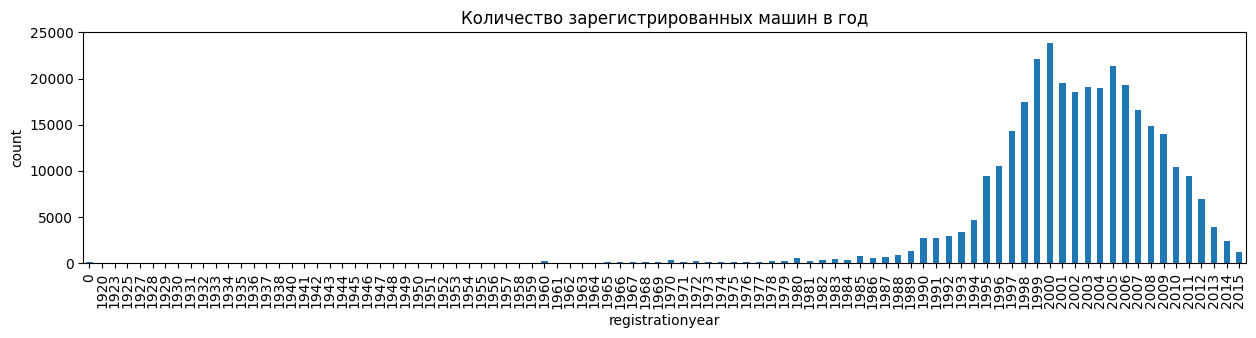

In [ ]:
# found out incorrect values of registration year, let's look at all unique values
display(np.sort(autos['registrationyear'].unique()))

# count the number of records with incorrect data - cars with a release date less than 1915 and older than 2019
print('\nNumber of records with incorrect year of manufacture values: ', autos[(autos['registrationyear']<1920)|(autos['registrationyear']>2019)]['registrationyear'].count())

# replace incorrect values with 0
autos.loc[(autos['registrationyear']<1920)|(autos['registrationyear']>2019),'registrationyear'] = 0

# look at the distribution with correction
plt.figure(figsize=[15, 3])
autos['registrationyear'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('registrationyear')
plt.ylabel('count')
plt.title('Number of registered vehicles per year')
plt.show()

Количество уникальных значений моделей:  249


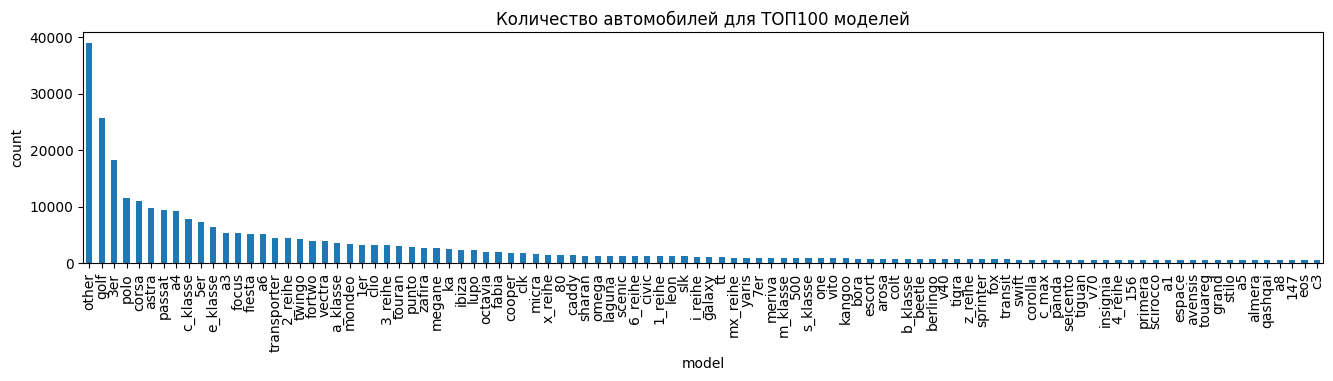

In [ ]:
# count the number of unique values of models
print('Count of unique model values: ', autos['model'].nunique())

# look at the distribution of cars by models for the first TOP100
plt.figure(figsize=[16, 3])
autos['model'].value_counts().head(100).plot(kind='bar')
plt.xlabel('model')
plt.ylabel('count')
plt.title('Number of cars for TOP 100 models')
plt.show()

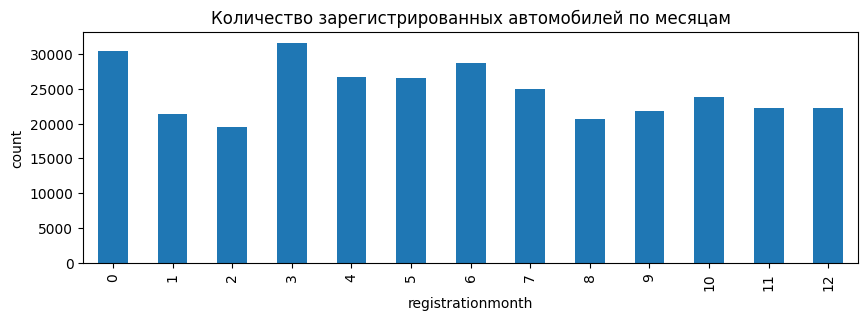

In [ ]:
# look at the distribution of cars by months
plt.figure(figsize=[10, 3])
autos['registrationmonth'].value_counts().sort_index().plot(kind='bar')
plt.ylabel('count')
plt.title('Number of registered vehicles by months')
plt.show();

Количество уникальных значений моделей:  40


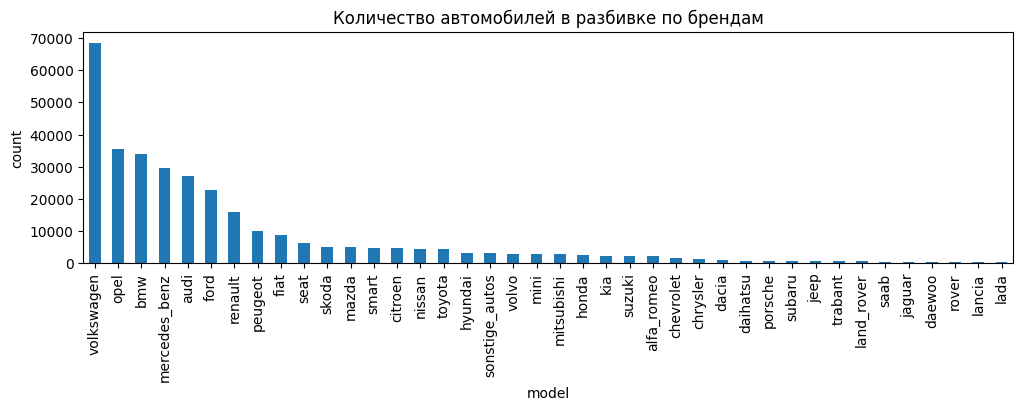

In [ ]:
# count the number of unique values of brands
print('Count of unique brand values: ', autos['brand'].nunique())

# look at the distribution of cars by brands
plt.figure(figsize=[12, 3])
autos['brand'].value_counts().plot(kind='bar')
plt.xlabel('model')
plt.ylabel('count')
plt.title('Count of vehicles broken down by brands')
plt.show()

Количество дат объявлений о продаже:  108


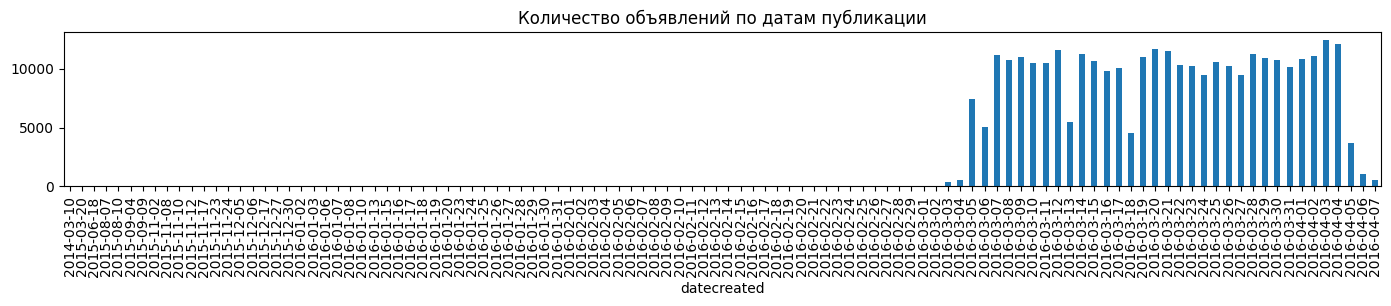

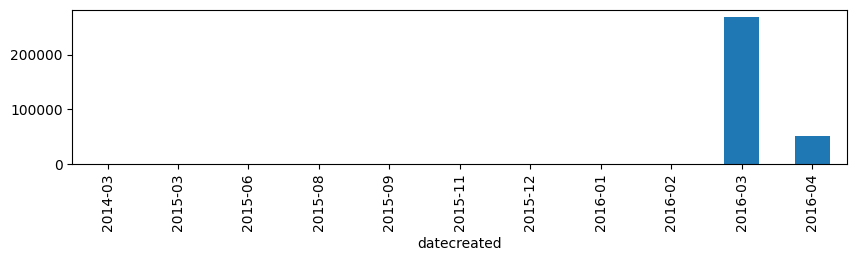

In [ ]:
# count the number of unique values in the datecreated column
print('Count of announcement dates for sale: ', autos['datecreated'].nunique())

# look at the distribution of dates
plt.figure(figsize=[17, 2])
plt.title('Number of announcements by publication date')
autos['datecreated'].dt.to_period('d').value_counts().sort_index().plot(kind='bar');

# look at the distribution of dates with grouping by months
plt.figure(figsize=[10, 2])
autos['datecreated'].dt.to_period('M').value_counts(ascending=True).sort_index().plot(kind='bar')
plt.show();

Количество почтовых кодов в объявлениях:  8129


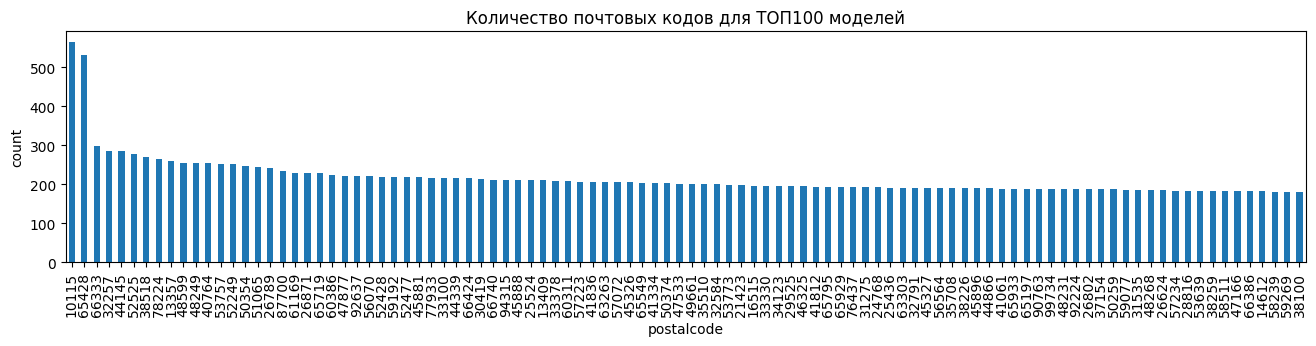

In [ ]:
# count unique values in postalcode column
print('Count of postal codes in announcements: ', autos['postalcode'].nunique())

# look at the distribution of postal codes for the first TOP100 
plt.figure(figsize=[16, 3])
autos['postalcode'].value_counts().head(100).plot(kind='bar')
plt.xlabel('postalcode')
plt.ylabel('count')
plt.title('Count of postal codes for TOP 100 models')
plt.show()

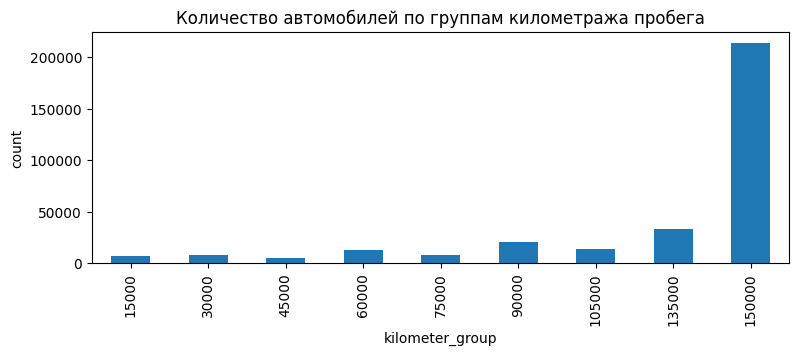

In [ ]:
# look at the distribution of cars by groups of mileage
plt.figure(figsize=[9, 3])
autos['kilometer_group'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('kilometer_group')
plt.ylabel('count')
plt.title('Count of vehicles by mileage categories')
plt.show()

**Conclusion**

After importing the data, we immediately converted column names and text values to lowercase across all columns, as well as date values to datetime type.

Next:

* We analyzed the values of categorical features 'vehicletype', 'gearbox', 'model', 'fueltype', 'brand','repaired' - missing values were replaced with category 'other', so that these records would not be lost during analysis, and taking into account the presence of the 'other' category in most of the mentioned features;
* We corrected typos and implicit duplicates in text columns 'model', 'fueltype';
* We removed records where the vehicle registration year is after the questionnaire download date, which is clearly incorrect;
* The column with photos is uninformative since it is filled only with zeros - we deleted it from the dataset, as well as the columns with timestamp data for loading the questionnaire and user activity;
* We deleted about 9 thousand obvious duplicates;
* We built histograms and box plots for quantitative features, which allowed us to identify outliers in the column with engine power (less than 15 and more than 500 horsepower) with a total of 33777 records;
* We replaced the above mentioned anomalies with several iterations, grouping data by model and year of production, then simply by model or brand;
* By prices we also identified anomalies with minimum prices for cars at the level of 0-100 in the amount of 11462, which, like power earlier, we corrected to median values, grouping data by models, years of release and mileage (added a separate feature with categories by mileage every 15 thousand kilometers traveled);
* By categorical features 'vehicletype', 'gearbox', 'fueltype', 'repaired' we built circular diagrams, from which we paid attention to the fuel type feature - the overwhelming majority of models are on gasoline at 90.2%, followed by category 'other', which included unknown data for this feature. The next categories after these two are gas, hybrids, electric batteries, summing up less than 2% of vehicles, in such a case the usefulness of the feature for training the model is doubtful, since one of the classes is present in the overwhelming majority of records, and the second includes 'others', which would not allow effectively evaluating the contribution of each class during training;
* When analyzing data by years of release we detected 266 records with abnormal values (less than 1920 year and more than 2019), replaced them with 0, as a result the main mass of vehicles by year of production is in the interval from 1980 to 2018, other years correspond to rare and rare items;
* When analyzing by months of registration we detected significant part of vehicles with unspecified month of registration (0 on the graph), the rest of the vehicles are distributed evenly across all months;
* Frequency analysis by models and brands showed only the largest group of models 'other', including missing data, other data for specified features are distributed in decreasing order from most well-known and popular sales brands (VW, Opel, BMW, MB, Audi, Ford) and their models (golf, 3er, corsa, astra, passat, a4, c-klasse, e-klasse);
* Analysis of the placement date of ads showed that the overwhelming majority of ads were published in March and April 2016, i.e. data are downloaded for one month from the beginning of March to the beginning of April;
* The number of locations by postal codes of ads is 8129 and distribution is evenly decreasing, according to the graph of the first 100 codes;
* According to synthetic feature with categories by mileage - more than half of vehicles have a mileage exceeding 135 thousand kilometers. When training models it can be tested and evaluated the contribution of this feature and possibly exclude it.

<a id='Checking-data-correlation'></a> 
## Checking data correlation
[Back to content](#To-contents)

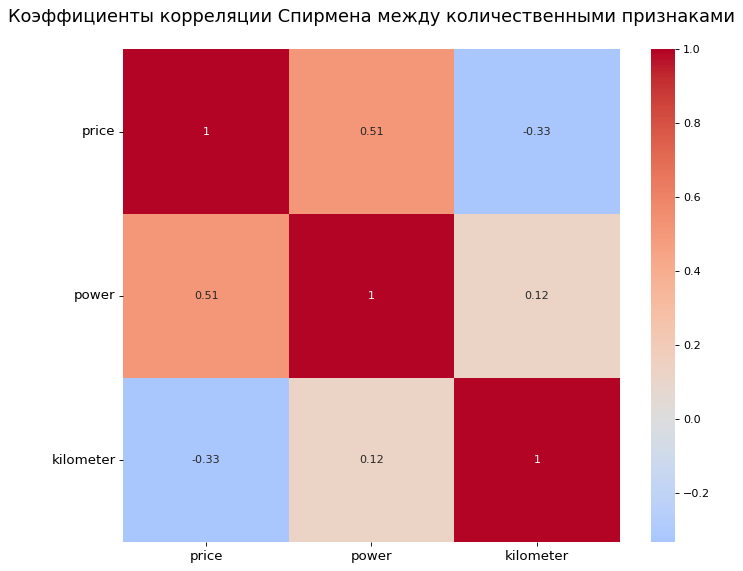

In [ ]:
# build  correlation matrix
columns_num = ['price', 'power', 'kilometer']
# as our data is not normally distributed, we will use Spearman's coefficient
plt.figure(figsize=(10,8), dpi= 80)
sns.heatmap(autos[columns_num].corr(method='spearman'), 
                        xticklabels=autos[columns_num].corr(method='spearman').columns, 
                        yticklabels=autos[columns_num].corr(method='spearman').columns, 
                        cmap='coolwarm' , 
                        center=0, 
                        annot=True)

plt.title('Spearman correlation coefficients between quantitative features\n', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2024121. Are interval variables set correctly?
  warnings.warn(


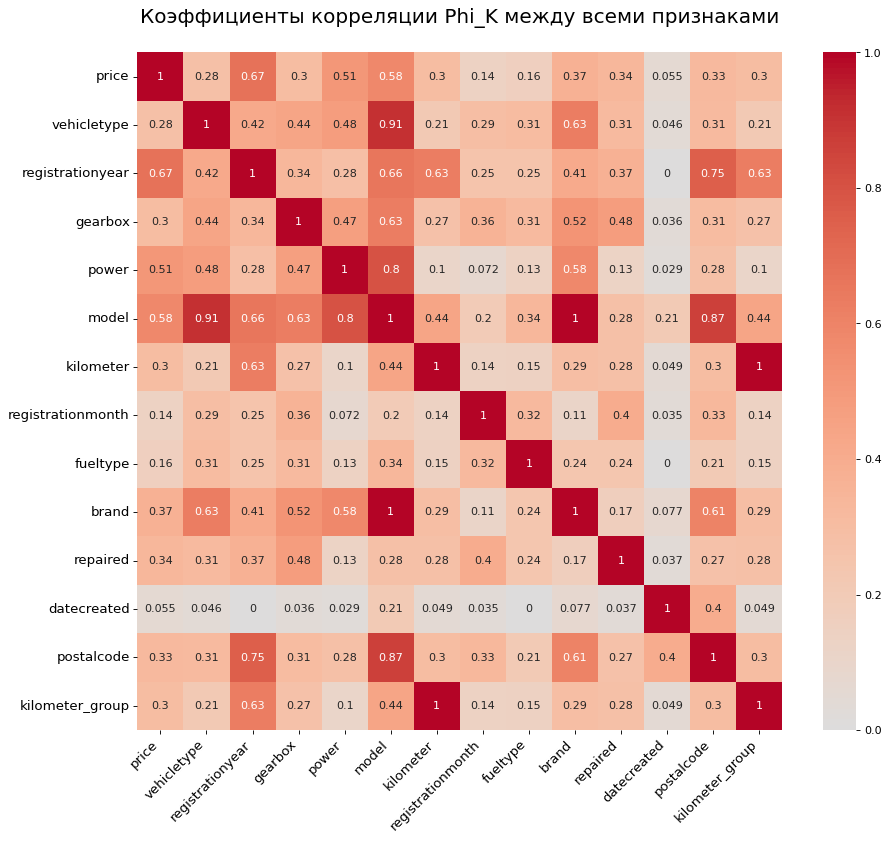

In [ ]:
# calculation of the correlation matrix using the Phi_K coefficient
phik_matrix = autos.phik_matrix(interval_cols=['price', 'power', 'kilometer'])

# loak at the heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, cmap='coolwarm', center=0, annot=True)

plt.title('Coefficients of correlation Phi_K between all characteristics\n', fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

In [43]:
autos = autos.drop(columns=['datecreated', 'fueltype', 'kilometer_group','registrationmonth'])

autos.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,brand,repaired,postalcode
0,480,other,1993,manual,101,golf,150000,volkswagen,other,70435
1,18300,coupe,2011,manual,190,other,125000,audi,yes,66954


**Conclusion**

Correlation of the target feature with quantitative characteristics is at the level of Spearman coefficient: -0.33 with mileage and 0.51 with engine power.

Checking correlation between all features by Phi_K method showed relationships with the target feature for most input features, except for the creation date of the ad:

1) since our dataset was essentially a one-month dump, the spread of dates was negligible; in such cases as selling cars, prices of cars are usually stable enough if ads were for a year, it would be possible to observe changes due to changes in the economy and market as a whole;
2) the type of fuel feature is not very informative, with minimal correlation - we exclude it;
3) also, the month of vehicle registration is poorly correlated with price, which is logical - when buying a car, attention is paid to the year, not the month, especially in this feature there is a significant noisy class, so we exclude it too;

Earlier formed synthetic feature for mileage groups showed the same relationship as the main mileage feature, and they are absolutely correlated, so we can get rid of it to improve model training quality.

We also found an extremely high correlation between input features: brand, model, and car type, which is logical, since specific types of cars and models correspond to specific brands, and there are no overlapping lines for cars by brands. Considering a significant pool of values "other" for the model feature and car type, it will complicate training the model, and having a brand feature will play a positive role here - so we won't exclude any of these features.

In [ ]:
# count of values in column model
value_counts = autos['model'].value_counts()

# filtering values that occur less than 10 times - otherwise errors are thrown when training
filtered_values = value_counts[value_counts >= 10].index

# filtering DataFrame based on these values
autos = autos[autos['model'].isin(filtered_values)]

autos.shape

(320346, 10)

<a id='Training-models'></a> 
## Training models
[Back to content](#To-contents)

Firstly, we will form datasets for training and testing models. Then, we will create pipelines for data preparation and model training.

In [ ]:
# set the constants
RANDOM_STATE = 42
TEST_SIZE = 0.15


In [ ]:
# form samples for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    autos.drop('price', axis=1),
    autos['price'],
    test_size = TEST_SIZE,
    stratify=autos['model'],
    random_state = RANDOM_STATE)

display(X_train.shape,y_train.shape)
display(X_train.head(),y_train.head())

(272294, 9)

(272294,)

,vehicletype,registrationyear,gearbox,power,model,kilometer,brand,repaired,postalcode
74088,wagon,2002,manual,90,focus,150000,ford,other,66839
143889,convertible,1998,manual,192,z_reihe,150000,bmw,no,85221
74863,small,1990,manual,103,fiesta,150000,ford,no,73061
8229,sedan,1984,manual,184,7er,150000,bmw,no,27729
59224,convertible,2001,manual,170,other,150000,bmw,no,92729


74088     1450
143889    8900
74863     1000
8229      6800
59224     6200
Name: price, dtype: int64

In [ ]:
# make lists of columns
be_columns = ['vehicletype', 'gearbox', 'postalcode', 'model', 'brand', 'repaired']
num_columns = ['registrationyear', 'power', 'kilometer']

# replace missing values with the most frequent value
X_train[be_columns] = X_train[be_columns].fillna(X_train[be_columns].mode().iloc[0])
X_test[be_columns] = X_test[be_columns].fillna(X_test[be_columns].mode().iloc[0])

be_pipe = Pipeline(
    [
     ('be', BinaryEncoder())
    ]
)

# make a general pipeline for data preparation
data_preprocessor= ColumnTransformer(
    [('be', be_pipe, be_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [ ]:
# count the number of features after preprocessing
max_features = data_preprocessor.fit_transform(X_train).shape[1]
display(max_features)

# look at the names of the columns after encoding
display(data_preprocessor.get_feature_names_out())


26

array(['be__vehicletype_0', 'be__vehicletype_1', 'be__vehicletype_2',
       'be__vehicletype_3', 'be__gearbox_0', 'be__gearbox_1',
       'be__postalcode', 'be__model_0', 'be__model_1', 'be__model_2',
       'be__model_3', 'be__model_4', 'be__model_5', 'be__model_6',
       'be__model_7', 'be__brand_0', 'be__brand_1', 'be__brand_2',
       'be__brand_3', 'be__brand_4', 'be__brand_5', 'be__repaired_0',
       'be__repaired_1', 'num__registrationyear', 'num__power',
       'num__kilometer'], dtype=object)

In [ ]:
%%time

# make the final pipeline for simple Linear Regression: data preparation and model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

# set the "empty" set of hyperparameters for training with the default model settings
param_grid = [

    # dictionary for LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler()]
    }
]


# grid search of the best hyperparameters
grid_search_0 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# train the model
model_0 = grid_search_0.fit(X_train, y_train)

# bring out the negMSE metric and convert it to RMSE
best_score_neg_mse_0 = model_0.best_score_
best_score_rmse_0 = round(float(np.sqrt(-best_score_neg_mse_0)),3)

CPU times: user 2.06 s, sys: 259 ms, total: 2.32 s
Wall time: 3.7 s


In [ ]:
%%time

# make the final pipeline for decision tree: prepare data and model
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

# set the "empty" set of hyperparameters for training with default model settings
param_grid_1 = [

     # dictionary for DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler()]
    }
]


# grid search for DecisionTreeRegressor
grid_search_1 = GridSearchCV(
    pipe_final_1, 
    param_grid_1, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# train the model
model_1 = grid_search_1.fit(X_train, y_train)

# bring out the negMSE metric and convert it to RMSE
best_score_neg_mse_1 = model_1.best_score_
best_score_rmse_1 = round(float(np.sqrt(-best_score_neg_mse_1)),3)

CPU times: user 3.46 s, sys: 355 ms, total: 3.82 s
Wall time: 6.85 s


In [ ]:
%%time

# make the final pipeline for LGBM: data preparation and model
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE,verbosity=-1))
])

# set the "empty" set of hyperparameters for training with the default settings of the model
param_grid_2 = [

     # dictionary for LGBMRegressor()
    {
        'preprocessor__num': [StandardScaler()]
    }
]

# grid search of the best hyperparameters
grid_search_2 = GridSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# train the model
model_2 = grid_search_2.fit(X_train, y_train)

# bring out the negMSE metric and convert it to RMSE
best_score_neg_mse_2 = model_2.best_score_
best_score_rmse_2 = round(float(np.sqrt(-best_score_neg_mse_2)),3)

CPU times: user 3.67 s, sys: 952 ms, total: 4.62 s
Wall time: 6.62 s


In [ ]:
%%time

# final pipeline for CatBoost is not formed:
# prepare data is not required - we feed the original sets X_train, y_train and the model is one

estimator = CatBoostRegressor(silent=True)
cat_features = ['vehicletype', 'gearbox', 'model', 'brand', 'repaired','postalcode']

# set of hyperparameters is not defined yet
param_grid_3 = [

     # dictionary for CatBoostRegressor()
    {
        'iterations': [100] #on default 1000 trees, corrected to 100 as in LGBM
    }
]

# grid search of the best hyperparameters
grid_search_3 = GridSearchCV(
    estimator, 
    param_grid_3, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# train the model
model_3 = grid_search_3.fit(X_train, y_train,cat_features=cat_features)

# bring out the negMSE metric and convert it to RMSE
best_score_neg_mse_3 = model_3.best_score_
best_score_rmse_3 = round(float(np.sqrt(-best_score_neg_mse_3)),3)

CPU times: user 11 s, sys: 720 ms, total: 11.7 s
Wall time: 9.19 s


<a id='Models-analysis'></a> 
## Models analysis
[Back to content](#To-contents)

Basic models LinearRegression and DecisionTreeRegression with standard parameters showed weaker results in terms of RMSE metric, 3254 and 2247 respectively. Linear regression failed to meet the requirements relative to the target benchmark of 2500 euros, while the decision tree slightly below it:

In [ ]:
print(f'RMSE metric for linear regression model considering cross-validation: {best_score_rmse_0}')
print(f'Training time of the linear regression model: {grid_search_0.cv_results_["mean_fit_time"][0]} с.')
print(f'Prediction time of the linear regression model: {grid_search_0.cv_results_["mean_score_time"][0]} с.')

Метрика RMSE модели линейной регрессии с учетом кросс-валидации: 3254.497
Время обучения модели линейной регрессии: 1.0210281372070313 с.
Время предсказания модели линейной регрессии: 0.07873706817626953 с.


In [ ]:
print(f'RMSE metric for decision tree model considering cross-validation: {best_score_rmse_1}')
print(f'Training time of the decision tree model: {grid_search_1.cv_results_["mean_fit_time"][0]} с.')
print(f'Prediction time of the decision tree model: {grid_search_1.cv_results_["mean_score_time"][0]} с.')

Метрика RMSE модели решающего дерева с учетом кросс-валидации: 2247.931
Время обучения модели решающего дерева: 2.2276954650878906 с.
Время предсказания модели решающего дерева: 0.10209102630615234 с.


Ensembles of decision trees LightGBM and CatBoost showed significantly stronger results, 1763 and 1708 respectively:

In [ ]:
print(f'RMSE metric for LightGBM model considering cross-validation: {best_score_rmse_2}')
print(f'Training time of the LightGBM model: {grid_search_2.cv_results_["mean_fit_time"][0]} с.')
print(f'Prediction time of the LightGBM model: {grid_search_2.cv_results_["mean_score_time"][0]} с.')

Метрика RMSE модели LightGBM с учетом кросс-валидации: 1763.452
Время обучения модели LightGBM: 3.0314104557037354 с.
Время предсказания модели LightGBM: 0.15515880584716796 с.


In [ ]:
print(f'RMSE metric for CatBoost model considering cross-validation: {best_score_rmse_3}')
print(f'Training time of the CatBoost model: {grid_search_3.cv_results_["mean_fit_time"][0]} с.')
print(f'Prediction time of the CatBoost model: {grid_search_3.cv_results_["mean_score_time"][0]} с.')

Метрика RMSE модели CatBoost с учетом кросс-валидации: 1707.699
Время обучения модели CatBoost: 5.891043329238892 с.
Время предсказания модели CastBoost: 0.04814620018005371 с.


Based on the target metric RMSE, the best result is achieved by the CatBoost ensemble (1708 euros), while in terms of training time, CatBoost (5.9 seconds) lags behind simpler linear regression models (1 second) and decision trees (2.2 seconds). However, it outperforms all other models in terms of prediction speed with a result of 0.04 seconds.

Considering the significant advantage in terms of target metric quality and prediction speed, we will further test only CatBoost. We will check several hyperparameters for this model and verify the best variant on the test dataset.

In [ ]:
%%time

# the final pipeline for CatBoost is not formed:
# preparation of the data is not required - we pass the original sets X_train, y_train and the model one

estimator = CatBoostRegressor(silent=True)
cat_features = ['vehicletype', 'gearbox', 'model', 'brand', 'repaired','postalcode']

# set the parameters for the grid search
param_grid_4 = [

     # dictionary for CatBoostRegressor()
    {
        'depth': [6,10],
        'iterations': [50, 100]
    }
]

# grid search for CatBoostRegressor
grid_search_4 = GridSearchCV(
    estimator, 
    param_grid_4, 
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=False,
    n_jobs=-1
)

# train the model
model_4 = grid_search_4.fit(X_train, y_train,cat_features=cat_features)

# bring out the negMSE metric and convert it to RMSE
best_score_neg_mse_4 = model_4.best_score_
best_score_rmse_4 = round(float(np.sqrt(-best_score_neg_mse_4)),3)

CPU times: user 20.7 s, sys: 1.58 s, total: 22.3 s
Wall time: 30.1 s


In [ ]:
print(f'RMSE metric for CatBoost model considering cross-validation: {best_score_rmse_4}')
print(f'Training time of the CatBoost model: {grid_search_4.cv_results_["mean_fit_time"].mean()} с.')
print(f'Prediction time of the CatBoost model: {grid_search_4.cv_results_["mean_score_time"].mean()} с.')
print(f'Best parameters of the CastBoost model: {grid_search_4.best_params_}')

Метрика RMSE модели CatBoost с учетом кросс-валидации: 1659.959
Время обучения модели CatBoost: 8.763763999938964 с.
Время предсказания модели CastBoost: 0.07679954767227173 с.
Лучшие параметры модели CastBoost: {'depth': 10, 'iterations': 100}


In [ ]:
# check the model on the test sample
y_test_pred4 = model_4.predict(X_test)
print(f'RMSE metric for CatBoost model on the test sample: {round(np.sqrt(mean_squared_error(y_test, y_test_pred4)),3)}')

Метрика RMSE на тестовой выборке: 1643.659


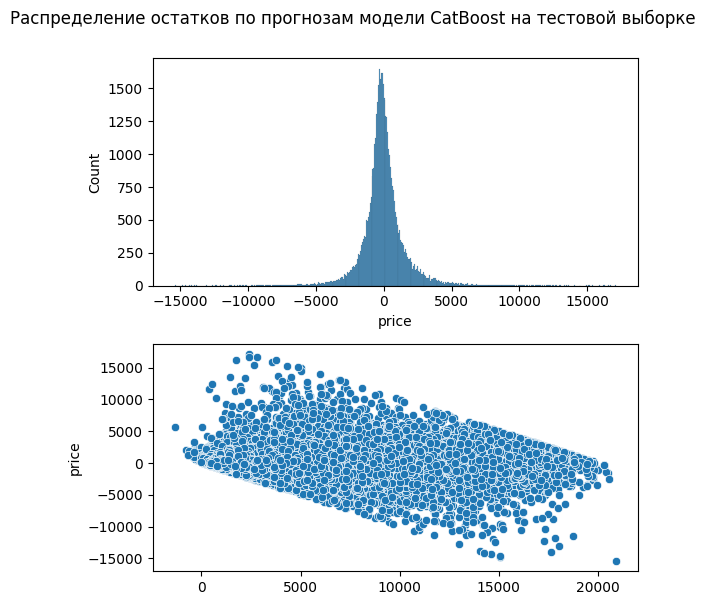

In [ ]:
# check the  residuals
fig, axes = plt.subplots(2,1,figsize=(6, 6))
fig.suptitle('Distribution of residuals by predictions of the CatBoost model on the test sample', y=1)

ost = y_test - y_test_pred4
ax = axes[0]
sns.histplot(data=ost, ax=ax)

ax = axes[1]
sns.scatterplot(x=y_test_pred4, y=y_test - y_test_pred4,ax=ax);

plt.tight_layout();
plt.show();

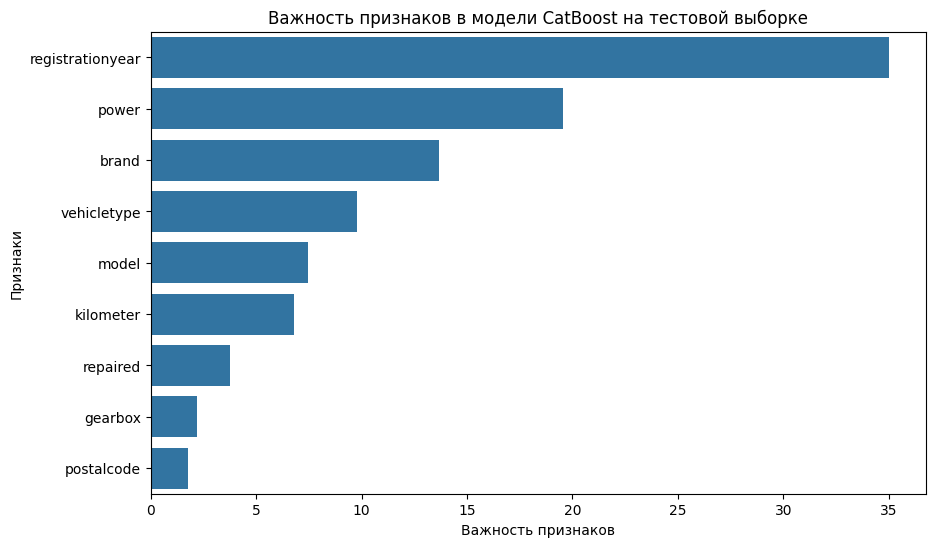

In [ ]:
# check feature importance
feature_importances = grid_search_4.best_estimator_.get_feature_importance()
feature_names = X_train.columns

# make dataFrame and sort by importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# make plot with feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.title("Feature importance in CatBoost model on the test sample")
plt.show()

With the best parameters ('depth': 10, 'iterations': 100), the CatBoost model on the test sample showed a result of the target metric RMSE of 1643 euros, further improving its predictive ability relative to the standard set of parameters.

The analysis of residuals showed that they are distributed more or less according to the Student's distribution, without several peaks and outliers. However, the residual scatter plot shows clear dependencies on predicted values, meaning that not all patterns were discovered during training and the residuals are not randomly distributed, likely due to the fact that the data was formed synthetically.

The feature importance analysis highlighted the contribution of the vehicle's year of release, engine power, brand, body type, and car model; mileage, transmission type, and place of sale - are less significant.

<a id='General-conclusion'></a> 
## General conclusion
[Back to content](#To-content)

After importing the data, a **data preprocessing** was performed and missing values in the 'vehicletype', 'gearbox', 'model', 'fueltype', 'brand','repaired' categories were filled with the category 'other'.

Next, corrections of typos and implicit duplicates were made, the column with photos was removed since it is only filled with zeros, and columns with time data for submitting a questionnaire and last user activity were deleted because these technical parameters do not affect the price. Also, records with the year of vehicle registration after the year of submission of the application were excluded as obviously erroneous, in particular, the year of vehicle registration is one of the main parameters for predicting the price (further analysis of trained models confirmed this). After that, approximately 9 thousand explicit duplicates were deleted.

**Exploratory data analysis** with histograms and boxplots for quantitative features allowed to identify outliers in the column with \_engine\_power (less than 15 and more than 500 horsepower) totaling 33777. These anomalies were replaced by median values, grouping the data by model and year of release, and on subsequent iterations only by model or brand.

For \_prices\_, similar anomalies were identified with minimum prices for cars in the range of 0-100 euros totaling 11462, which were also corrected to median values, grouping the data by models, years of release and mileage (a separate feature was added with categories every 15 thousand kilometers of mileage).

For categorical features 'vehicletype', 'gearbox', 'fueltype', 'repaired' circular diagrams were built, from which attention was drawn to the fuel type feature - a dominant majority of 90.2% cars are on gasoline, followed by the category 'other', where unknown data for this feature are also included, and then gas, hybrids, electric batteries forming less than 2% of vehicles, in such case the usefulness of the feature for training the model is doubtful, which was confirmed later by a very low correlation with the target feature - the fuel type feature was deleted.

When analyzing data on \_year\_of_release\_, 266 records with anomalous values (less than 1920 and more than 2019) were identified, replaced with 0, and it was found that most cars are in the range from 1980 to 2018, while other years correspond to rare and rare specimens.

When analyzing the distribution by \_month\_of_registration\_, a significant part of cars with unknown month of registration (0 on the graph) were identified, while the remaining vehicles are distributed evenly across all months. Considering that the month of primary vehicle registration has little effect on the price (unlike the year), and low correlation was found later between this feature and the target one - this feature was also excluded from the training dataset.

Frequency analysis by \_models\_, \_brands\_, showed only the largest group 'other' including missing data, while other data for these features are distributed in a decreasing order of most popular and sold brands (VW, Opel, BMW, MB, Audi, Ford) and their models (golf, 3er, corsa, astra, passat, a4, c-klasse, e-klasse).

Analysis of \_posting\_date\_, showed that the overwhelming majority of announcements were published in March and April 2016, i.e., data was loaded for a month from the beginning of March to the beginning of April - at such case, the effect of the posting date on the price is minimal since the market is more inertial and the posting date may be informative for longer periods (from a quarter and more). Correlation between this feature and the target one was found to be near-zero, therefore this feature was also deleted.

The number of locations by \_postal\_codes\_, totals 8129, and the distribution is uniformly decreasing, correlation with this feature was also found to be near-zero - the feature was excluded.

**Correlation** between the target feature and quantitative features exists at a level of Spearman's coefficient -0.33 with mileage and 0.51 with engine power. Correlation check by the Phi_K method showed connections with the target feature for most input features, except date of creation of announcement and low correlation with fuel type, month of vehicle registration.

A previously formed synthetic feature of mileage in groups showed the same connection as the main feature of mileage, moreover they are perfectly correlated - therefore this feature was also abandoned to improve the quality of training models.

High correlation between input features for brand, model and car type was found which is logical since specific types of cars and models correspond to certain brands, while lines of cars do not overlap between brands. Considering a significant pool of values 'other' by the feature of model and car type, this will make it difficult to train a model, in such case presence of brand will play a positive role - therefore we did not decide to exclude any of these features.

During **training of models**, simple linear regression (with standard parameters) and decision trees (also with standard parameters), as well as ensembles of decision trees LightGBM and CatBoost were prepared.
By the target metric RMSE, the best result was obtained for the ensemble CatBoost (1708 euros), while by the time of training Catboost (5.7 seconds) lagged behind more simple linear regression models (1 second) and decision tree (2.2 seconds), and also in terms of prediction speed exceeded all other models with a result of 0.04 seconds.

Considering a significant advantage in terms of quality and speed of forecasting, we left only CatBoost for further tuning and testing.

**With the best parameters ('depth': 10, 'iterations': 100) the model CatBoost on the test dataset showed the result of target metric RMSE 1643 euros, improving predictive ability relative to standard parameters.**

Residual analysis showed that they are distributed approximately according to the t-distribution without several peaks and outliers; residual scatter plot shows obvious dependencies from predicted values, i.e., not all patterns were revealed at the stage of training and residuals are distributed non-randomly, most probably this is due to synthetic formation of data.

**Importance of features** analysis underlined contribution of year of vehicle release, engine power, brand, car body type and model; mileage, transmission type and sale location - less significant.